## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction


For this project, you will be working to understand the results of an A/B test run by an e-commerce website. We goal is to  through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [71]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [72]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


b. Use the below cell to find the number of rows in the dataset.

In [74]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [75]:
len(np.unique(df["user_id"]))

290584

d. The proportion of users converted.

In [76]:
df["converted"].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [77]:
x = len(df.query('landing_page != "new_page" & group == "treatment"'))
x2 = len(df.query('landing_page == "new_page" & group != "treatment"'))
(x+x2)

3893

f. Do any of the rows have missing values?

In [78]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [79]:
df2 = df.copy()
df2 = df2.drop(df2.query('group == "treatment" & landing_page != "new_page" ').index)
df2 = df2.drop(df2.query('group == "control" & landing_page != "old_page" ').index)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [80]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [81]:
df2["user_id"].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [82]:
df2[(df2["user_id"].duplicated())]["user_id"]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [83]:
df2[(df2["user_id"].duplicated())]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [84]:
df2 = df2.drop_duplicates(["user_id"])
df2[(df2["user_id"].duplicated())]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [85]:
df2["converted"].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [86]:
df2[df2["group"]=="control"]["converted"].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [87]:
df2[df2["group"]=="treatment"]["converted"].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [88]:
(df2["landing_page"]=="new_page").mean()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**No ,I don't think there is sufficient evidence to say that the new treatment page leads to more conversions.
Becouse probability they converted from  "control group" (0.12) biger than probability they converted from "the treatment group" 
(0.1188)**

<a id='ab_test'></a>
### Part II - A/B Test
  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0:  p_{old} >= p_{new} $$

$$H_1: p_{old} < p_{new} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>


a. What is the **convert rate** for $p_{new}$ under the null? 

In [89]:
p_new = df2["converted"].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [90]:
p_old = df2["converted"].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [91]:
n_new = (df2["landing_page"] == "new_page").sum()
n_new

145310

d. What is $n_{old}$?

In [92]:
n_old = (df2["landing_page"] == "old_page").sum()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [93]:
new_page_converted = np.random.choice([0,1], n_new ,p=[(1-p_new),p_new]).mean()
new_page_converted

0.11959947698024913

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [94]:
old_page_converted = np.random.choice([0,1], n_old ,p=[(1-p_old),p_old]).mean()
old_page_converted

0.11931247160538018

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [95]:
new_page_converted - old_page_converted

0.0002870053748689483

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [96]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], n_new ,p=[(1-p_new),p_new]).mean()
    old_page_converted = np.random.choice([0,1], n_old ,p=[(1-p_old),p_old]).mean()
    p_diffs.append(new_page_converted - old_page_converted)


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [97]:
df2_control_converted = df2[df2["group"]=="control"]["converted"].mean()
df2_treatment_converted = df2[df2["group"]=="treatment"]["converted"].mean()
group_diffs = (df2_treatment_converted - df2_control_converted)

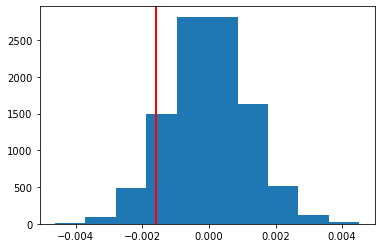

In [98]:
plt.hist(p_diffs)
plt.axvline(x=group_diffs ,color="r" ,linewidth=2);


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [103]:
(p_diffs >= np.array(group_diffs)).mean()    # p

0.905

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

$$ α(0.05) <  p (0.905) $$

This  means that there is no sufficient evidence for  reject the null  hypothesis ($H_0$) and that we do not have sufficient evidence that the new_page has a higher conversion rate than the old_page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [104]:
import statsmodels.api as sm

convert_old = (df2[df2["group"]=="control"]["converted"]).sum()
convert_new =  (df2[df2["group"]=="treatment"]["converted"]).sum()

n_old = (df2["landing_page"] == "old_page").sum()
n_new = (df2["landing_page"] == "new_page").sum()

"convert_old={} , convert_new={} , n_old={} , n_new={}".format(convert_old , convert_new , n_old , n_new )

'convert_old=17489 , convert_new=17264 , n_old=145274 , n_new=145310'

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [105]:
(z_score, p_value) = sm.stats.proportions_ztest([convert_old , convert_new ], [n_old , n_new ], alternative='smaller')
"z_score={} , p_value={}".format(z_score, p_value)

'z_score=1.3109241984234394 , p_value=0.9050583127590245'

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**meaning of the z-score (1.31) and the p_value (0.905) for old_page and new_page.that there is no sufficient evidence for reject the null hypothesis   ( 𝐻0 ). And because of (p_value > 0.05)That  we can not be confident with a 95% confidence level  that the new_page has a higher conversion rate than the old_page.
yes, they do agree with the findings in parts j. and k..**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Regression should you be performing  is "a logistic regression".**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [106]:
import statsmodels.api as sm
df2["intercept"] = 1

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [107]:
df2[["control" ,'ab_page']]= pd.get_dummies(df2['group'])
df2 = df2.drop("control" ,axis=1 )
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [108]:
logit_convert = sm.Logit(df2["converted"], df2[["intercept" ,"ab_page"]])
result = logit_convert.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 12 Sep 2021   Pseudo R-squ.:               8.077e-06
Time:                        21:43:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**the p-value associated with ab_page is (0.19)
differ from the value you found in Part II because that the Logit Regression is based on a two-tailed test (predict only two possible outcames).**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

 **yes ,over there other things that might influence  converted ,like nationality, age, gender or country ..**
**but may the model gets more complexe.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  

In [109]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [110]:
count = df_new["country"].unique()# the country.
count

array(['UK', 'US', 'CA'], dtype=object)

In [111]:
### Create the necessary dummy variables
df_new[count]= pd.get_dummies(df_new['country'])
df_new = df_new.drop("UK" ,axis=1 )
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,CA
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [113]:
logit_country = sm.Logit(df_new["converted"], df_new[["intercept" ,"US" ,"CA"]])
result = logit_country.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 12 Sep 2021   Pseudo R-squ.:               1.521e-05
Time:                        21:44:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0507      0.028      1.786      0.074      -0.005       0.106
CA             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

#### $$α(0.05) <  p_(us)( 0.074),p_(ca)(0.129)$$

### This mean  the country does not influence on the convertion rate .

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [114]:
### Create the necessary additional columns.

df_new["us_page"] = df_new["US"] * df_new["ab_page"] # US(1) with(*) new_page(1) >>> 1
df_new["ca_page"] = df_new["CA"] * df_new["ab_page"] # CA(1) with(*) new_page(1) >>> 1
df_new.head() 

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,CA,us_page,ca_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,1,0


In [116]:
### Fit Your Linear Model And Obtain the Results.

logit_general = sm.Logit(df_new["converted"], df_new[["intercept" , "ab_page" ,"US" ,"CA" ,"us_page" ,"ca_page"]])
result = logit_general.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 12 Sep 2021   Pseudo R-squ.:               3.482e-05
Time:                        21:44:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0118      0.040      0.296      0.767      -0.066       0.090
CA             0.0175      0.038      0.465      0.642      -0.056       0.091
us_page        0.0783      0.057      1.378      0.168      -0.033       0.190
ca_page        0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

#### $$ α(0.05) <  p_(all) $$

### This mean the country and the page  do not influence on the convertion rate.

<a id='conclusions'></a>
## Conclusions
**1-that there is no sufficient evidence for reject the null hypothesis ( 𝐻0 ) , and that we do not have sufficient evidence that the new_page has a higher conversion rate than the old_page.**

**2-the country and the page do not influence on the convertion rate.**
####  ** And from the above from analysis results would bias me toward suggesting to drop the new page.**


In [117]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

1